<a href="https://colab.research.google.com/github/BingHungLee/BHAI-Daily-Practice/blob/main/%5B20210715%5D_NH3_usage_prediction_for_SCR_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np                
import pandas as pd              
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

from matplotlib import pyplot    
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split  
from sklearn import metrics

In [3]:
!git clone https://github.com/BingHungLee/Dataset.git

Cloning into 'Dataset'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 48 (delta 18), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [4]:
cd /content/Dataset

/content/Dataset


In [6]:
df_0 = pd.read_csv("HYSCR.csv",header =2,index_col =0,parse_dates=True,squeeze=False) 
df_0

,coal T/H,OFA T/H,steam flow T/H,GAH inlet O2 %,NOx inlet ppm,ECO outlet temp C,FDF flow T/H,FDF current A,ammonia actual L/HR,stack flow NM3/H,NOx stack ppm,stack O2 %
time,,,,,,,,,,,,
2021-05-24 00:00:00,55.304115,42.715000,494.679565,3.606840,117.500000,380.624115,450.707703,67.082214,170.042999,519586.1563,34,4.100000
2021-05-24 00:01:00,55.303406,42.870003,494.649719,3.608348,117.500000,380.643066,450.705414,67.081169,170.059525,516950.0938,34,4.100000
2021-05-24 00:02:00,55.302696,42.814999,494.619873,3.609855,117.500000,380.662048,450.703125,67.080124,170.076065,524077.5938,34,4.100000
2021-05-24 00:03:00,55.301991,43.015396,494.589996,3.611363,117.500000,380.681030,450.700836,67.079086,170.092606,527261.3750,34,4.100000
2021-05-24 00:04:00,55.301281,42.815395,494.560150,3.612871,117.500000,380.699982,450.698547,67.078041,170.109131,530751.0625,34,4.100000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-06 23:56:00,48.740509,42.628273,416.178619,3.610745,123.067322,353.241791,376.109558,56.500000,164.920258,451640.4688,32,4.253667
2021-06-06 23:57:00,48.740532,42.451469,416.164856,3.607482,123.059601,353.224915,376.110596,56.500000,165.045990,451696.5000,32,4.254084
2021-06-06 23:58:00,48.740551,42.651470,416.151093,3.604220,123.051880,353.208038,376.111633,56.500000,165.171722,448002.9063,32,4.254501


## Data Observation and Preprocessing

In [7]:
#Check NAN Values
df_0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15506 entries, 2021-05-24 00:00:00 to 2021-06-07 00:00:00
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   coal T/H             15506 non-null  float64
 1   OFA T/H              15506 non-null  float64
 2   steam flow T/H       15506 non-null  float64
 3   GAH inlet O2 %       15506 non-null  float64
 4   NOx inlet ppm        15506 non-null  float64
 5   ECO outlet temp C    15506 non-null  float64
 6   FDF flow T/H         15506 non-null  float64
 7   FDF current A        15506 non-null  float64
 8   ammonia actual L/HR  15506 non-null  float64
 9   stack flow NM3/H     15506 non-null  float64
 10  NOx stack ppm        15506 non-null  int64  
 11  stack O2 %           15506 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.5 MB


In [8]:
#Drop NOx inlet ppm and NOx stack ppm
df_1 = df_0.drop(['NOx inlet ppm','NOx stack ppm'],axis =1)
df_1

,coal T/H,OFA T/H,steam flow T/H,GAH inlet O2 %,ECO outlet temp C,FDF flow T/H,FDF current A,ammonia actual L/HR,stack flow NM3/H,stack O2 %
time,,,,,,,,,,
2021-05-24 00:00:00,55.304115,42.715000,494.679565,3.606840,380.624115,450.707703,67.082214,170.042999,519586.1563,4.100000
2021-05-24 00:01:00,55.303406,42.870003,494.649719,3.608348,380.643066,450.705414,67.081169,170.059525,516950.0938,4.100000
2021-05-24 00:02:00,55.302696,42.814999,494.619873,3.609855,380.662048,450.703125,67.080124,170.076065,524077.5938,4.100000
2021-05-24 00:03:00,55.301991,43.015396,494.589996,3.611363,380.681030,450.700836,67.079086,170.092606,527261.3750,4.100000
2021-05-24 00:04:00,55.301281,42.815395,494.560150,3.612871,380.699982,450.698547,67.078041,170.109131,530751.0625,4.100000
...,...,...,...,...,...,...,...,...,...,...
2021-06-06 23:56:00,48.740509,42.628273,416.178619,3.610745,353.241791,376.109558,56.500000,164.920258,451640.4688,4.253667
2021-06-06 23:57:00,48.740532,42.451469,416.164856,3.607482,353.224915,376.110596,56.500000,165.045990,451696.5000,4.254084
2021-06-06 23:58:00,48.740551,42.651470,416.151093,3.604220,353.208038,376.111633,56.500000,165.171722,448002.9063,4.254501


In [9]:
#Assess parameter correlation
df_1.corr()

,coal T/H,OFA T/H,steam flow T/H,GAH inlet O2 %,ECO outlet temp C,FDF flow T/H,FDF current A,ammonia actual L/HR,stack flow NM3/H,stack O2 %
coal T/H,1.000000,0.547060,0.978031,-0.709856,0.813759,0.960025,0.979059,-0.495420,0.934071,-0.718714
OFA T/H,0.547060,1.000000,0.576088,-0.169916,0.584204,0.647854,0.606285,-0.153639,0.554233,-0.202981
steam flow T/H,0.978031,0.576088,1.000000,-0.683035,0.881713,0.983855,0.986302,-0.494336,0.942288,-0.718652
GAH inlet O2 %,-0.709856,-0.169916,-0.683035,1.000000,-0.533135,-0.613504,-0.647519,0.734602,-0.687451,0.841458
ECO outlet temp C,0.813759,0.584204,0.881713,-0.533135,1.000000,0.890533,0.874640,-0.507970,0.829308,-0.624434
FDF flow T/H,0.960025,0.647854,0.983855,-0.613504,0.890533,1.000000,0.986914,-0.443026,0.933533,-0.650417
FDF current A,0.979059,0.606285,0.986302,-0.647519,0.874640,0.986914,1.000000,-0.459747,0.937813,-0.679650
ammonia actual L/HR,-0.495420,-0.153639,-0.494336,0.734602,-0.507970,-0.443026,-0.459747,1.000000,-0.522597,0.758652
stack flow NM3/H,0.934071,0.554233,0.942288,-0.687451,0.829308,0.933533,0.937813,-0.522597,1.000000,-0.723942
stack O2 %,-0.718714,-0.202981,-0.718652,0.841458,-0.624434,-0.650417,-0.679650,0.758652,-0.723942,1.000000


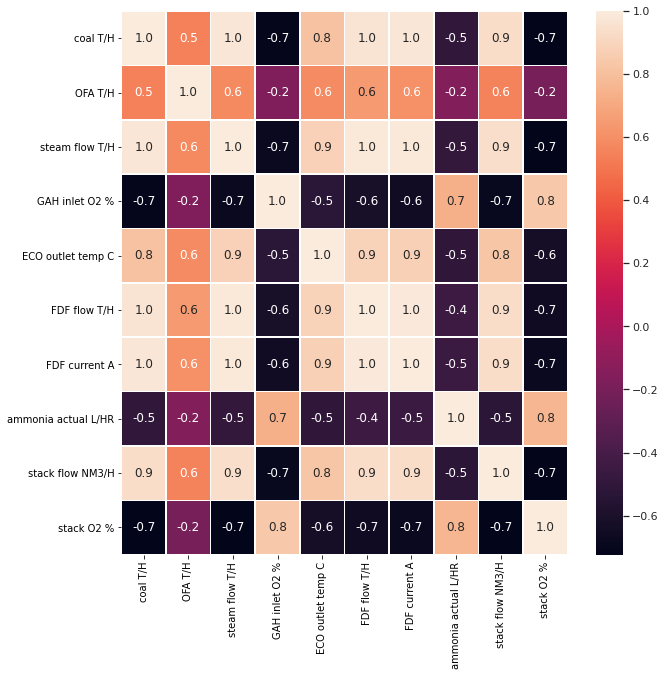

In [10]:
#Draw Heat Map

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.set(style="whitegrid")
sns.heatmap(df_1.corr(), annot=True, fmt="0.1f", linewidths=.5, ax=ax)

In [11]:
#Drop more un-relevant parameters
df_2 = df_1.drop(['OFA T/H','stack flow NM3/H'],axis=1)

## Define X and Y value

In [12]:
X = df_2.values
X

array([[ 55.3041153 , 494.6795654 ,   3.60684013, ...,  67.08221436,
        170.0429993 ,   4.0999999 ],
       [ 55.30340576, 494.6497192 ,   3.60834789, ...,  67.08116913,
        170.0595245 ,   4.0999999 ],
       [ 55.30269623, 494.619873  ,   3.60985541, ...,  67.0801239 ,
        170.0760651 ,   4.0999999 ],
       ...,
       [ 48.74055099, 416.1510925 ,   3.60421991, ...,  56.5       ,
        165.1717224 ,   4.25450087],
       [ 48.74057007, 416.1373291 ,   3.60095739, ...,  56.5       ,
        165.2974396 ,   4.25491762],
       [ 48.74059296, 416.1235657 ,   3.5999999 , ...,  56.5       ,
        165.423172  ,   4.25533438]])

In [13]:
y = df_2['ammonia actual L/HR'].values
y

array([170.0429993, 170.0595245, 170.0760651, ..., 165.1717224,
       165.2974396, 165.423172 ])

## Split Train and Test Data

In [14]:
from sklearn.model_selection import train_test_split 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=45)

In [20]:
neighbors = np.arange(1,10)                         #Set Container include 9 spots
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

## Apply KNN Model

* Reference: [Python enumerate() 函数](https://www.runoob.com/python/python-func-enumerate.html)

In [23]:
#Decide K
for i,k in enumerate(neighbors):
    knn = KNeighborsRegressor(n_neighbors=k)

 * Reference: [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
 * Reference: [機器學習-ml-gridsearchcv-網格搜尋](https://martychen920.blogspot.com/2017/09/ml-gridsearchcv.html)
 * Reference: [Day 05：神經網路的效能調校](https://ithelp.ithome.com.tw/articles/10234203)
 * Reference: [Python机器学习笔记：Grid SearchCV（网格搜索）](https://www.cnblogs.com/wj-1314/p/10422159.html)

In [24]:
from sklearn.model_selection import GridSearchCV                  #Import Optimize Solution Package:"GridSearchCV"
knn_grid = {'n_neighbors':[ i for i in range (1,10)]}             #在1~10中找尋最好的鄰居數
grid_search = GridSearchCV(knn,param_grid = knn_grid,)            #knn是模型名稱
grid_search.fit(X_train, y_train)                                 #對X_train, y_train做GridSearchCV訓練

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=9, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
from sklearn.decomposition   import PCA             #載入主成分分析(PCA)套件
pca = PCA (n_components=2)                          #將PCA函式命名為pca變數，並降維到維度為2
X_train = pca.fit_transform(X_train)                #對X_train變數做PCA訓練及轉換
X_test = pca.transform(X_test)                      #對X_test變數做PCA轉換
print(X_train.shape)                                #印出X_train的維度
print(X_test.shape)                                 #印出X_test的維度

(10389, 2)
(5117, 2)


In [26]:
#對X_train, y_train做KNN模型訓練
knn.fit(X_train, y_train)  

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='uniform')

In [27]:
train_accuracy[i] = knn.score(X_train, y_train) 
test_accuracy[i] = knn.score(X_test, y_test)
train_accuracy[i]

0.9996947601997224

In [28]:
test_accuracy[i]

0.9994975878002136

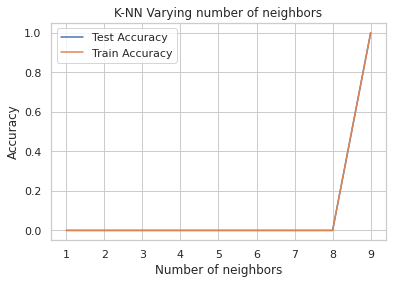

In [29]:
plt.title('K-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Test Accuracy')
plt.plot(neighbors, train_accuracy, label='Train Accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [30]:
y_pred = knn.predict(X_test)
#print("AI預測量:",list(y_pred))
#print("實際量:",list(y_test))

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

r2_score(y_test, y_pred)

0.9994975878002136

In [32]:
#載入相關繪圖套件
import matplotlib.pyplot as plt
import os

In [33]:
X_all = pca.fit_transform(X)         #將所有X值傳回模組, 進行預測
y_pred_all = knn.predict(X_all)

In [34]:
#計算 ammonia actual L/min與 AI predict L/min準確率
r2_score(y, y_pred_all)

0.9996132401401604

In [35]:
#計算 ammonia actual L/min與 AI predict L/min準確率
#此處無法命名為 AI_accuracy[i], 故沿用名稱 test_accuracy[i]
test_accuracy[i] = knn.score(X_all, y_pred_all) 
test_accuracy[i]

1.0

In [ ]:
#type(y_pred_all)        #確認 y_pred_all型式為陣列

In [36]:
df_2.loc[:,'AI predict L/HR'] = pd.Series(y_pred_all, index=df_2.index)  
#將 y_pred_all加入 df_2中, 並命名為 AI predict L/min
df_2.head()    #檢視 df_2

,coal T/H,steam flow T/H,GAH inlet O2 %,ECO outlet temp C,FDF flow T/H,FDF current A,ammonia actual L/HR,stack O2 %,AI predict L/HR
time,,,,,,,,,
2021-05-24 00:00:00,55.304115,494.679565,3.606840,380.624115,450.707703,67.082214,170.042999,4.1,170.149551
2021-05-24 00:01:00,55.303406,494.649719,3.608348,380.643066,450.705414,67.081169,170.059525,4.1,170.149551
2021-05-24 00:02:00,55.302696,494.619873,3.609855,380.662048,450.703125,67.080124,170.076065,4.1,170.149551
2021-05-24 00:03:00,55.301991,494.589996,3.611363,380.681030,450.700836,67.079086,170.092606,4.1,170.149551
2021-05-24 00:04:00,55.301281,494.560150,3.612871,380.699982,450.698547,67.078041,170.109131,4.1,170.149551


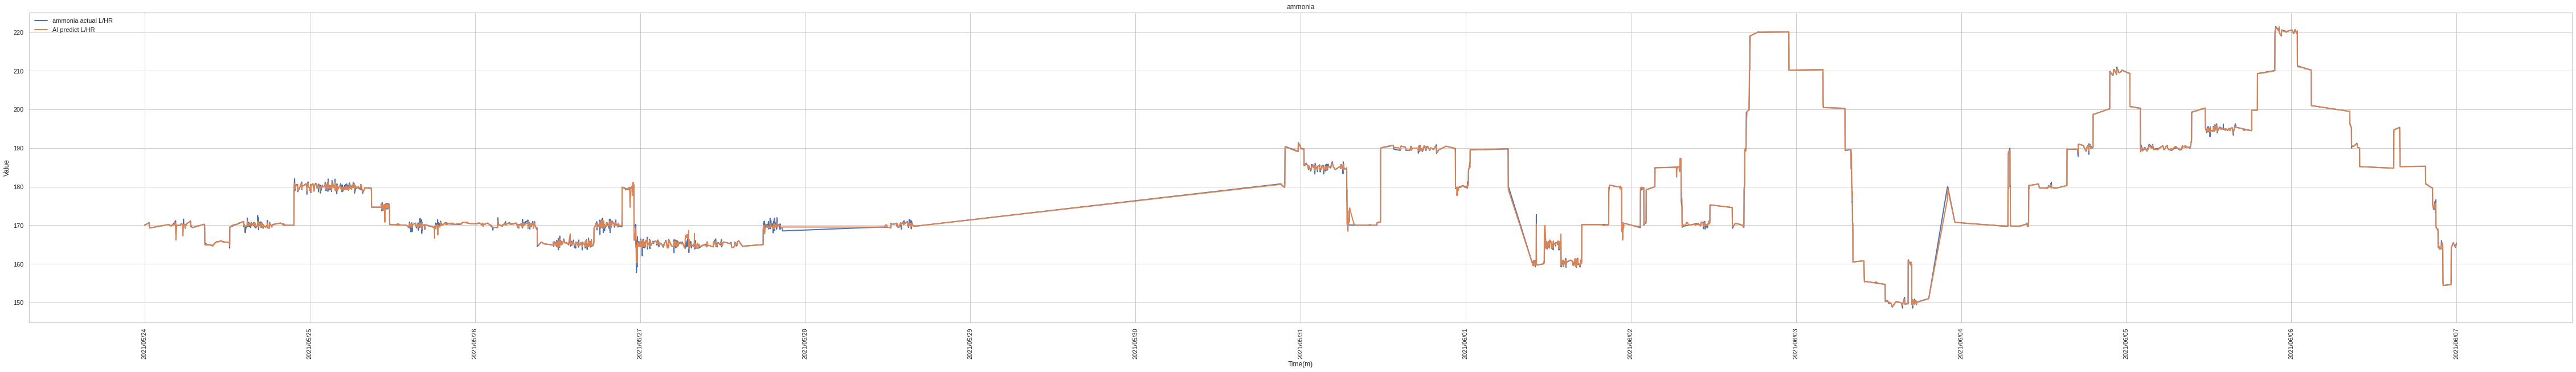

In [37]:
# 建立fig:畫布面板跟 axes:一張圖表
fig, axes = plt.subplots(figsize=(80,10))

# 圖表外觀設定 : seaborn-darkgrid
plt.style.use('seaborn-darkgrid')

# x軸:時間數列 ; y軸:各項參數
plt.plot(df_2.index, df_2['ammonia actual L/HR'], label = 'ammonia actual L/HR', linewidth = 2)

plt.plot(df_2.index, df_2['AI predict L/HR'], label = 'AI predict L/HR', linewidth = 2)
#plt.plot(df_2.index, df_2['ammonia theory L/HR'], label = 'ammonia theory L/HR', linewidth = 2)
#以下兩參數程式保留, 但暫不畫出
#plt.plot(df_0.index, df_0['Nox difference ppm'], label = 'Nox difference ppm', linewidth = 2)
#plt.plot(df_0.index, df_0['steam flow T/H'], label = 'steam flow T/H', linewidth = 2)

# X軸旋轉字體(90度)
plt.xticks(rotation=90)

# WeekdayLocator(星期), DayLocator(日) 
axes.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# 設定時間格式
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))

# x軸單位:Time ; y軸單位:氨水用量 ; 圖的標題:ammonia; 設定圖示說明:loc=2(左上角)
plt.xlabel("Time(m)")
plt.ylabel("Value")
plt.title("ammonia")
plt.legend(loc=2)

# 儲存成圖片，dpi為解析度單位
plt.savefig("ammonia_0.png", dpi = 100)